In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "Dados/data.csv"
df = pd.read_csv(file_path)

plt.scatter(df['Time'], df['Resistance'])
plt.xlabel('Time [s]')
plt.ylabel('Resistance [Ω]')
plt.show()

## Estimação por ODR da resistência no instante 0

In [ ]:
import numpy as np
from scipy import odr

####### Replicando o artigo de referência #######

# Incertezas de medição:

s_t0 = 1 # Incerteza do tempo inicial

s_dt = 0.001 # Incerteza do tempo de aquisição

s_dR = 0.001 # Incerteza da medição de resistência

# Modelo da função
def estimation_model(params, x):
    return params[1] * x + params[0]

# Prepara dados
x = df['Time'].values
y = df['Resistance'].values

# Passa incerteza para x e y
s_x = np.sqrt(s_t0**2 + s_dt**2)
s_y = s_dR

# Define o modelo
model = odr.Model(estimation_model)

# Create objeto RealData
data = odr.RealData(x, y, sx = s_x, sy = s_y)

# Seta parâmetro iniciais
initial_params = [1.0, 1.0]

# ODR fit
odr_fit = odr.ODR(data, model, beta0=initial_params)
result = odr_fit.run()

# Fitted parameters
intercept, slope = result.beta

# Desvio padrão dos parâmetros estimados
uncertainty = result.sd_beta

print("Uncertainty:", uncertainty)
print("Slope:", slope)
print("Intercept:", intercept)

R2 = intercept
s_R2 = uncertainty[1]

## Conversão da resistência para temperatura

In [ ]:
R1 = 15.39 # Resistência no início do teste
Tamb_1 = 24 # Temperatura ambiente no início do teste
Tamb_2 = 24 # Temperatura ambiente no início do teste

k = 234.5 # Recíproco do coeficiente de temperatura do resistor
alpha = 1/(k+Tamb_1) # Coeficiente de temperatura do resistor

s_R1 = 0.01 # Incerteza da medição de resistência no início do teste
s_Tamb1 = 0.1 # Incerteza da medição de temperatura no início do teste
s_Tamb2 = 0.1 # Incerteza da medição de temperatura no final do teste


# Usando equação do artigo IEEE LATAM

# Cálculo da variação de temperatura 
def T2_LATAM(R2):
    return (R2-R1)/(R1*alpha) + Tamb_1

dT1 = T2_LATAM(R2) - Tamb_1

def uncertainty_LATAM(R2,s_R2):
    s_dT = [1*s_Tamb1, # Incerteza da temperatura ambiente
            -R2/(alpha*(R1**2))*s_R1, # Incerteza da resistência inicial
            1/(alpha*R1)*s_R2] # Incerteza da resistência final

    return np.linalg.norm(s_dT) # Incerteza combinada é a raiz da soma dos quadrados

s_dT1 = uncertainty_LATAM(R2,s_R2)

print("IEEE LATAM")
print("Temperature rise [K]:", dT1)
print("Uncertainty [K]:", s_dT1)
print('\n')

# Usando equação do artigo do Int J Thermophys, com correção
# na ordem de R1 e R2

# Cálculo da variação de temperatura 
def T2_TERMOP(R2):
    return (R2-R1)/R1*(k+Tamb_1)-(Tamb_2-Tamb_1)
dT2 = T2_TERMOP(R2)-Tamb_1

def uncertainty_TERMOP(R2,s_R2):
    s_dT = [((R2-R1)/R1 + 1)*s_Tamb1, # Incerteza da temperatura ambiente inicial
         -1*s_Tamb2, # Incerteza da temperatura ambiente final
         -R2*(k+Tamb_1)/(R1**2)*s_R1, # Incerteza da resistência inicial
         (k+Tamb_1)/R1*s_R2] # Incerteza da resistência final
    
    return np.linalg.norm(s_dT) # Incerteza combinada é a raiz da soma dos quadrados

s_dT2 = uncertainty_TERMOP(R2,s_R2)

print("Int J Thermophys")
print("Temperature rise [K]:", dT2)
print("Uncertainty [K]:", s_dT2)

### Estimação de modelo exponencial usando função própria

In [ ]:
from fcn import estimate_model_with_uncertainty

# Estimando o modelo exponencial com incerteza

params, uncertainty, result = estimate_model_with_uncertainty(x, y, s_x, s_y, model='exp', initial_params= [20,1,-1],maxit = 10000)

R2 = params[0] + params[1]

def uncertainty_exp(x):
        s_R2 = [1*uncertainty[0], # Incerteza do parâmetro 0
                np.exp(params[2]*x)*uncertainty[1], # Incerteza do parâmetro 1
                x*params[1]*np.exp(params[2]*x)*uncertainty[2], # Incerteza do parâmetro 2
                params[1]*params[2]*np.exp(params[2]*x)*s_x, # Incerteza de x (t0)
                ]
        return np.linalg.norm(s_R2) # Incerteza combinada é a raiz da soma dos quadrados

# Incerteza p/ x = 0:
x_s = 0
s_R2 = uncertainty_exp(x_s)

print("Resistance at t0:", R2)
print("Uncertainty for t0:", s_R2)
print("Estimated temperature at t0:", T2_LATAM(R2))
print("Uncertainty for estimated temperature at t0:", uncertainty_LATAM(R2,s_R2))
print("f(x) = ", params[0], '+', params[1], 'exp(', params[2], 'x)')
print("SSE:", result.sum_square)
result.pprint()

def exp_model(params, x):
            return params[0] + params[1] * np.exp(params[2] * x)

x_plot = np.insert(x, 0, 0)
s_R= [uncertainty_exp(xx) for xx in x_plot]
plt.plot(x_plot, exp_model(params, x_plot), color='red', label='ODR Estimation')
plt.fill_between(x_plot, exp_model(params, x_plot) - s_R, exp_model(params, x_plot) + s_R, color='red', alpha=0.3, label='Estimation uncertainty')
plt.errorbar(x, y, yerr=s_y, xerr=s_x, fmt='none', label='Original data with uncertainty')
plt.xlabel('Time [s]')
plt.ylabel('Resistance [Ω]')
plt.legend()
plt.show()

In [ ]:
# Estimando o modelo linear com incerteza

params, uncertainty, result = estimate_model_with_uncertainty(x, y, s_x, s_y, model='lin', maxit = 10000)

R2 = params[0]

def lin_model(params, x):
    return params[0] + params[1] * x

def uncertainty_lin(x):
        s_R2 = [1*uncertainty[0], # Incerteza do parâmetro 0
                x*uncertainty[1], # Incerteza do parâmetro 1
                params[1]*s_x, # Incerteza de x (t0)
                ]
        return np.linalg.norm(s_R2) # Incerteza combinada é a raiz da soma dos quadrados

# Incerteza p/ x = 0:
x_s = 0
s_R2 = uncertainty_lin(x_s)

print("Resistance at t0:", R2)
print("Uncertainty for t0:", s_R2)
print("Estimated temperature at t0:", T2_LATAM(R2))
print("Uncertainty for estimated temperature at t0:", uncertainty_LATAM(R2,s_R2))
print("f(x) = ", params[0], '+', params[1], 'x')
print("SSE:", result.sum_square)
result.pprint()

x_plot = np.insert(x, 0, 0)
s_R= [uncertainty_lin(xx) for xx in x_plot]
plt.plot(x_plot, lin_model(params, x_plot), color='red', label='ODR Estimation')
plt.fill_between(x_plot, lin_model(params, x_plot) - s_R, lin_model(params, x_plot) + s_R, color='red', alpha=0.3, label='Estimation uncertainty')
plt.errorbar(x, y, yerr=s_y, xerr=s_x, fmt='none', label='Original data with uncertainty')
plt.xlabel('Time [s]')
plt.ylabel('Resistance [Ω]')
plt.legend()
plt.show()

In [ ]:
import numpy as np

x0 = np.array([69.1,69.3,69.6])
x1 = np.array([66.3,68.3,69.1]) 
x = np.array([65.6,68.1,70.0])
x3 = np.array([62.1,65.6,73.3])

s_x0 = np.std(x0)/(2*np.sqrt(3))
s_x1 = np.std(x1)/(2*np.sqrt(3))
s_x = np.std(x)/(2*np.sqrt(3))
s_x3 = np.std(x3)/(2*np.sqrt(3))

print(np.linalg.norm([s_x0,10e-3,1e-3]))
print(np.linalg.norm([s_x1,10e-3,1e-3]))
print(np.linalg.norm([s_x,10e-3,1e-3]))
print(np.linalg.norm([s_x3,10e-3,1e-3]))


In [ ]:
from fcn import *

s_t0 = 1 # Incerteza do tempo inicial

s_dt = 0.001 # Incerteza do tempo de aquisição

s_dR = 0.001 # Incerteza da medição de resistência

# Condições de teste

R1 = 15.39 # Resistência no início do teste
Tamb_1 = 24 # Temperatura ambiente no início do teste
Tamb_2 = 24 # Temperatura ambiente no início do teste

k = 234.5 # Recíproco do coeficiente de temperatura do resistor
alpha = 1/(k+Tamb_1) # Coeficiente de temperatura do resistor

s_R1 = s_dR # Incerteza da medição de resistência no início do teste
s_Tamb1 = 0.1 # Incerteza da medição de temperatura no início do teste
s_Tamb2 = 0.1 # Incerteza da medição de temperatura no final do teste

T2 = final_temperature()

## Análise sensibilidade incertezas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("Resultados/map_results.csv")

cases = [{'dt': [2],
        'Npoints': [19],
        't1': [4]},

        {'dt': [10],
        'Npoints': [3],
        't1': [10]},

        {'dt': [2],
        'Npoints': [3],
        't1': [4]},

        {'dt': [2],
        'Npoints': [3],
        't1': [20]}
]

uncertainty_vars = ['s_dR', 's_t0', 's_dt', 's_R1', 's_Tamb1', 's_Tamb2', 's_cvol']

uncertainty_df = pd.DataFrame(columns=['dt','N_points','t1']+uncertainty_vars)

row_i = 0

for case in cases:
    condition = (df['dt'] == case['dt'][0]) & (df['Npoints'] == case['Npoints'][0]) & (df['t1'] == case['t1'][0])
    specific_condition = (df[uncertainty_vars] != 0).sum(axis=1)
    filtered_df = df[condition & (specific_condition==1)]

    if filtered_df.empty:
        continue
    
    uncertainty_df.loc[row_i, 'dt'] = case['dt'][0]
    uncertainty_df.loc[row_i, 'N_points'] = case['Npoints'][0]
    uncertainty_df.loc[row_i, 't1'] = case['t1'][0]

    for var in uncertainty_vars:
        row_unc = filtered_df[filtered_df[var] != 0]
        if not row_unc.empty:
            uncertainty_df.loc[row_i, var] = row_unc['std_T2'].values[0]

    row_i = row_i+1
    


In [ ]:
# Convert uncertainty_df to numeric for plotting
uncertainty_df.iloc[:, 3:] = uncertainty_df.iloc[:, 3:].apply(pd.to_numeric)

# Set up the plot
x = np.arange(len(uncertainty_vars))  # the label locations
width = 0.2  # the width of the bars

cm = 1/2.54 
fig, ax = plt.subplots(figsize=(14*cm, 7*cm))

# Plot each row in uncertainty_df as a group of bars
for i, row in uncertainty_df.iterrows():
    ax.bar(x + i * width, row[uncertainty_vars], width, label=f"dt={row['dt']}, N_points={row['N_points']}, t1={row['t1']}")

plt.rcParams['font.family'] = 'Times New Roman'

names = {'s_t0':'ut0',
         's_dt':'ut',
        's_dR':'uR',
        's_R1':'uR1',
        's_Tamb1':'uT1',
        's_Tamb2':'uT2',
        's_cvol':'uc'}

for label in ax.get_xticklabels():
    label.set_fontproperties('Times New Roman')

for label in ax.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Add labels, title, and legend
ax.set_xlabel('Uncertainty Variables', fontname='Times New Roman')
ax.set_ylabel('Uncertainty contribution [°C]', fontname='Times New Roman')
ax.set_xticks(x + 3*width/2)
xTickLabels = [names.get(var, var) for var in uncertainty_vars]
ax.set_xticklabels(xTickLabels)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os

if not os.path.exists("Gráficos"):
    os.makedirs("Gráficos")

fig.savefig(f"Gráficos/individualUncertainty.pdf")

In [ ]:
# Calculate the root of the squared sum of uncertainties for each case
uncertainty_df['root_squared_sum'] = uncertainty_df[uncertainty_vars].apply(
    lambda row: np.sqrt(np.sum(np.square(row.astype(float)))), axis=1
)

# Print the results
print(uncertainty_df[['dt', 'N_points', 't1', 'root_squared_sum']])

In [ ]:
from fcn import estimate_model_with_uncertainty
import warnings
import numpy as np

initial_params = [17.472,2.06,-0.0197]

def exp_model(params, x):
    # TODO: Add docstring

    return params[0] + params[1]*np.exp(params[2]*x)

baseValues = {'dt': [10],
            'Npoints': [3],
            't1': [10],
            'R1': [15.39],
            'Tamb1': [24],
            'Tamb2': [24],
            'cvol': [100],
            's_t0': [0.1],
            's_dt': [0.01],
            's_dR': [0.001],
            's_R1': [0.001],
            's_Tamb1': [0.2],
            's_Tamb2': [0.2],
            's_cvol': [1]}

dt = baseValues['dt'][0]
t1 = baseValues['t1'][0]
N_points = baseValues['Npoints'][0]

s_t0 = baseValues['s_t0'][0]
s_dt = baseValues['s_dt'][0]
s_dR = baseValues['s_dR'][0]

s_R1 = baseValues['s_R1'][0]
s_Tamb1 = baseValues['s_Tamb1'][0]
s_Tamb2 = baseValues['s_Tamb2'][0]
s_cvol = baseValues['s_cvol'][0]

file_path = "Dados/data.csv"
df = pd.read_csv(file_path)

x_og = df['Time'].values
y_og = df['Resistance'].values

x_tot = np.linspace(t1, t1 + (N_points-1)*dt, N_points)
ind = np.isin(x_og, x_tot)

if np.sum(ind) == 0:
    raise ValueError("None of the provided time data fits the desired configuration.")
elif np.sum(ind) < N_points:
    warnings.warn("Not all elements of the desired configuration are present in the provided time data. Proceeding with the available data.")

x_tot = x_og[ind]
y_tot = y_og[ind]

params, _, res = estimate_model_with_uncertainty(x_tot, y_tot, s_dt, s_dR, model=exp_model, initial_params= initial_params,maxit = 1000000)

print(res.cov_beta)

B0 = params[0]
B1 = params[1]
B2 = params[2]

s_B0 = np.sqrt(res.cov_beta[0][0])
s_B1 = np.sqrt(res.cov_beta[1][1])
s_B2 = np.sqrt(res.cov_beta[2][2])

In [ ]:


Tamb_1 = baseValues['Tamb1'][0]
Tamb_2 = baseValues['Tamb2'][0]
R1 = baseValues['R1'][0]
cvol = baseValues['cvol'][0]
t0 = 0

k = 25450/cvol-20

R2 = B0+B1*np.exp(B2*t0)

s_T2 = [((R2-R1)/R1 + 2)*s_Tamb1, # Uncertainty of initial ambient temperature
        -1*s_Tamb2, # Uncertainty of final ambient temperature
        -R2*(k+Tamb_1)/(R1**2)*s_R1, # Uncertainty of initial resistance
        -(R2-R1)/R1*25450/cvol**2*s_cvol, # Uncertainty of copper purity
        -R2*(k+Tamb_1)/(R1**2)*s_B0, # Uncertainty of beta0
        -np.exp(B2*t0)*R2*(k+Tamb_1)/(R1**2)*s_B1, # Uncertainty of beta1
        -t0*B1*np.exp(B2*t0)*R2*(k+Tamb_1)/(R1**2)*s_B2, # Uncertainty of beta2
        -B2*B1*np.exp(B2*t0)*R2*(k+Tamb_1)/(R1**2)*s_t0 # Uncertainty of t0
        ]

print(s_T2)

fig, ax = plt.subplots(figsize=(14*cm, 7*cm))
ax.bar(list(range(len(s_T2))), s_T2)

In [ ]:
def get_unc_GUM(baseValues):
    
    initial_params = [17.472,2.06,-0.0197]

    def exp_model(params, x):
        return params[0] + params[1]*np.exp(params[2]*x)

    dt = baseValues['dt'][0]
    t1 = baseValues['t1'][0]
    N_points = baseValues['Npoints'][0]

    s_t0 = baseValues['s_t0'][0]
    s_dt = baseValues['s_dt'][0]
    s_dR = baseValues['s_dR'][0]

    s_R1 = baseValues['s_R1'][0]
    s_Tamb1 = baseValues['s_Tamb1'][0]
    s_Tamb2 = baseValues['s_Tamb2'][0]
    s_cvol = baseValues['s_cvol'][0]

    file_path = "Dados/data.csv"
    df = pd.read_csv(file_path)

    x_og = df['Time'].values
    y_og = df['Resistance'].values

    x_tot = np.linspace(t1, t1 + (N_points-1)*dt, N_points)
    ind = np.isin(x_og, x_tot)

    if np.sum(ind) == 0:
        raise ValueError("None of the provided time data fits the desired configuration.")
    elif np.sum(ind) < N_points:
        warnings.warn("Not all elements of the desired configuration are present in the provided time data. Proceeding with the available data.")

    x_tot = x_og[ind]
    y_tot = y_og[ind]

    params, _, res = estimate_model_with_uncertainty(x_tot, y_tot, s_dt, s_dR, model=exp_model, initial_params= initial_params,maxit = 1000000)

    print(res.cov_beta)

    B0 = params[0]
    B1 = params[1]
    B2 = params[2]

    s_B0 = np.sqrt(res.cov_beta[0][0])
    s_B1 = np.sqrt(res.cov_beta[1][1])
    s_B2 = np.sqrt(res.cov_beta[2][2])

    Tamb_1 = baseValues['Tamb1'][0]
    Tamb_2 = baseValues['Tamb2'][0]
    R1 = baseValues['R1'][0]
    cvol = baseValues['cvol'][0]
    t0 = 0

    k = 25450/cvol-20

    R2 = B0+B1*np.exp(B2*t0)

    s_T2 = [((R2-R1)/R1 + 2)*s_Tamb1, # Uncertainty of initial ambient temperature
            -1*s_Tamb2, # Uncertainty of final ambient temperature
            -R2*(k+Tamb_1)/(R1**2)*s_R1, # Uncertainty of initial resistance
            -(R2-R1)/R1*25450/cvol**2*s_cvol, # Uncertainty of copper purity
            -R2*(k+Tamb_1)/(R1**2)*s_B0, # Uncertainty of beta0
            -np.exp(B2*t0)*R2*(k+Tamb_1)/(R1**2)*s_B1, # Uncertainty of beta1
            -t0*B1*np.exp(B2*t0)*R2*(k+Tamb_1)/(R1**2)*s_B2, # Uncertainty of beta2
            -B2*B1*np.exp(B2*t0)*R2*(k+Tamb_1)/(R1**2)*s_t0 # Uncertainty of t0
            ]
    
    T2 = Tamb_1+(R2+R1)/R1*(k+Tamb_1)-(Tamb_2-Tamb_1)
    
    return T2, np.linalg.norm(s_T2), s_T2

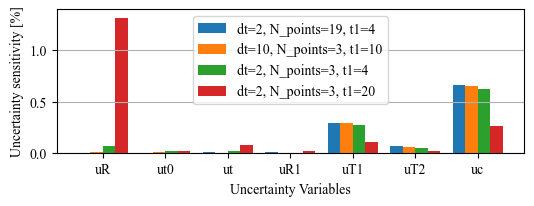

   dt N_points  t1      base      s_dR      s_t0      s_dt      s_R1  \
0   2       19   4  0.848989   0.84907  0.849031  0.848524  0.848429   
1  10        3  10  0.854224  0.854737  0.854869  0.854093  0.854378   
2   2        3   4  0.888513  0.894196  0.889765  0.889615  0.888516   
3   2        3  20  1.359376  1.538914  1.357561  1.369843  1.356526   

    s_Tamb1   s_Tamb2    s_cvol  
0   0.87382  0.854246   0.90503  
1  0.878979  0.859232  0.910287  
2  0.912685  0.892774  0.943471  
3  1.374141  1.361073  1.394516  


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("Resultados/map_results_sensitivity.csv")

baseValues = {'R1': [15.39],
            'Tamb1': [24],
            'Tamb2': [24],
            'cvol': [100],
            's_t0': [0.1],
            's_dt': [0.01],
            's_dR': [0.001],
            's_R1': [0.001],
            's_Tamb1': [0.2],
            's_Tamb2': [0.2],
            's_cvol': [1]}

cases = [{'dt': [2],
        'Npoints': [19],
        't1': [4]},

        {'dt': [10],
        'Npoints': [3],
        't1': [10]},

        {'dt': [2],
        'Npoints': [3],
        't1': [4]},

        {'dt': [2],
        'Npoints': [3],
        't1': [20]}
]

uncertainty_vars = ['s_dR', 's_t0', 's_dt', 's_R1', 's_Tamb1', 's_Tamb2', 's_cvol']

uncertainty_df = pd.DataFrame(columns=['dt','N_points','t1','base']+uncertainty_vars)

row_i = 0

for case in cases:
    condition = (df['dt'] == case['dt'][0]) & (df['Npoints'] == case['Npoints'][0]) & (df['t1'] == case['t1'][0])
    specific_condition = (df[uncertainty_vars] != 0).sum(axis=1)
    filtered_df = df[condition & (specific_condition>1)]

    if filtered_df.empty:
        continue
    
    uncertainty_df.loc[row_i, 'dt'] = case['dt'][0]
    uncertainty_df.loc[row_i, 'N_points'] = case['Npoints'][0]
    uncertainty_df.loc[row_i, 't1'] = case['t1'][0]

    baseCond  = filtered_df[
        (filtered_df['R1'] == baseValues['R1'][0]) &
        (filtered_df['Tamb1'] == baseValues['Tamb1'][0]) &
        (filtered_df['Tamb2'] == baseValues['Tamb2'][0]) &
        (filtered_df['cvol'] == baseValues['cvol'][0]) &
        (filtered_df['s_t0'] == baseValues['s_t0'][0]) &
        (filtered_df['s_dt'] == baseValues['s_dt'][0]) &
        (filtered_df['s_dR'] == baseValues['s_dR'][0]) &
        (filtered_df['s_R1'] == baseValues['s_R1'][0]) &
        (filtered_df['s_Tamb1'] == baseValues['s_Tamb1'][0]) &
        (filtered_df['s_Tamb2'] == baseValues['s_Tamb2'][0]) &
        (filtered_df['s_cvol'] == baseValues['s_cvol'][0])]
    
    if len(baseCond) != 1:
        raise ValueError("baseCond must have exactly one row.")

    uncertainty_df.loc[row_i, 'base'] = baseCond['std_T2'].values[0]

    for var in uncertainty_vars:
        row_unc = filtered_df[filtered_df[var] != baseValues[var][0]]
        if not row_unc.empty:
            uncertainty_df.loc[row_i, var] = row_unc['std_T2'].values[0]

    row_i = row_i+1
    
# Convert uncertainty_df to numeric for plotting
uncertainty_df.iloc[:, 3:] = uncertainty_df.iloc[:, 3:].apply(pd.to_numeric)

# Set up the plot
x = np.arange(len(uncertainty_vars))  # the label locations
width = 0.2  # the width of the bars

cm = 1/2.54 
fig, ax = plt.subplots(figsize=(14*cm, 5.5*cm))

# Plot each row in uncertainty_df as a group of bars
for i, row in uncertainty_df.iterrows():
    ax.bar(x + i * width, abs(100*row[uncertainty_vars]/row['base']-100)/10, width, label=f"dt={row['dt']}, N_points={row['N_points']}, t1={row['t1']}", color=f'C{i}')

plt.rcParams['font.family'] = 'Times New Roman'

names = {'s_t0':'ut0',
         's_dt':'ut',
        's_dR':'uR',
        's_R1':'uR1',
        's_Tamb1':'uT1',
        's_Tamb2':'uT2',
        's_cvol':'uc'}

for label in ax.get_xticklabels():
    label.set_fontproperties('Times New Roman')

for label in ax.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Add labels, title, and legend
ax.set_xlabel('Uncertainty Variables', fontname='Times New Roman')
ax.set_ylabel('Uncertainty sensitivity [%]', fontname='Times New Roman')
ax.set_xticks(x + 3*width/2)
ax.set_ylim(0, 1.4)
xTickLabels = [names.get(var, var) for var in uncertainty_vars]
ax.set_xticklabels(xTickLabels)
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.savefig("Gráficos/sensititivity.pdf")
plt.show()

print(uncertainty_df)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import odr
from typing import Union, Callable, List, Tuple, Optional

df = pd.read_csv("Dados/comp2.csv")

x = df['Time'].values[0:10]
y = df['Resistance'].values[0:10]

def exp_model(params, x):
    # TODO: Add docstring

    return params[0] + params[1]*np.exp(params[2]*x)

def estimate_model_with_uncertainty(x: Union[np.ndarray, List[float]],
                                    y: Union[np.ndarray, List[float]],
                                    s_x: Optional[Union[float, np.ndarray, List[float]]] = None,
                                    s_y: Optional[Union[float, np.ndarray, List[float]]] = None,
                                    model: Union[str, Callable] = 'lin',
                                    initial_params: Optional[List[float]] = None,
                                    **kwargs
                                    ) -> Tuple[np.ndarray, np.ndarray, odr.Output]:
    
    '''
    Estimates the parameters of a given model with associated uncertainties using Orthogonal Distance Regression (ODR).

    Parameters:
    - x (array-like): Independent variable data.
    - y (array-like): Dependent variable data.
    - s_x (scalar or array-like, optional): Standard deviations of the independent variable data. Default is None.
    - s_y (scalar or array-like, optional): Standard deviations of the dependent variable data. Default is None.
    - model (str or callable, optional): The model to fit. Can be 'lin' for a linear model, 'exp' for an exponential model, or a callable function. Default is 'lin'.
    - initial_params (list): Initial guess for the model parameters. Default is [1.0, 1.0] if model is 'lin' or [1.0, 1.0, 1.0] if model is 'exp'. If model is callable, initial_params must be provided.
    - **kwargs: Additional keyword arguments to be passed to the ODR fitting process.

    Returns:
    - fitted_params (array): Estimated parameters of the model.
    - uncertainty (array): Standard deviations of the estimated parameters.
    - result (odr.Output): Full output of the ODR fitting process, containing additional information such as the residuals and the covariance matrix.

    '''

    if not callable(model):
        if model == 'lin':
            def model(params, x):
                return params[1] * x + params[0]
            initial_params = [1.0, 1.0] if initial_params is None else initial_params

        elif model == 'exp':
            def model(params, x):
                return params[0] + params[1] * np.exp(params[2] * x)
            initial_params = [1.0, 1.0, 1.0] if initial_params is None else initial_params

        elif not callable(model):
            raise ValueError("Model must be a callable function or 'lin' or 'exp'.")
        
        elif callable(model) and initial_params is None:
            raise ValueError("Initial parameters must be provided when using a custom model.")

    # Define o modelo
    model = odr.Model(model)

    if s_x == 0:
        s_x = None
    if s_y == 0:
        s_y = None

    # Create objeto RealData
    data = odr.RealData(x, y, sx = s_x, sy = s_y)

    # ODR fit
    odr_fit = odr.ODR(data, model, beta0=initial_params, **kwargs)
    result = odr_fit.run()

    # Fitted parameters
    fitted_params = result.beta

    # Desvio padrão dos parâmetros estimados
    uncertainty = result.sd_beta

    return fitted_params, uncertainty, result


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

initial_params = [8.50468513, 0.03510031, -3.936979] 

df = pd.read_csv("Dados/comp1.csv")
df2 = pd.read_csv("Dados/comp2.csv")

n_lim = 15
t_lim = 4

t0 = 0.5

cm = 1/2.54  # centimeters in inches
plt.rcParams['font.family'] = 'Times New Roman'
# Create a figure and axis for temperature subplot
fig, (ax_top, ax_bottom) = plt.subplots(2, 2, figsize=(14*cm, 12*cm))

for ax in ax_bottom:
    fig.delaxes(ax)

ax_bottom = plt.subplot(2, 1, 2)

# First experiment (df)
x = df['Time'].values[0:n_lim] + t0
y = df['Resistance'].values[0:n_lim]
params, _, _ = estimate_model_with_uncertainty(x, y, model=exp_model, initial_params=initial_params, maxit=100000000)
x_fit = np.linspace(0, max(t_lim,x[-1]), 1000)
y_fit = exp_model(params, x_fit)
sse_exponential = np.sum((y - exp_model(params, x))**2)
linear_params = np.polyfit(x, y, 1)
linear_fit = np.polyval(linear_params, x_fit)
sse_linear = np.sum((y - np.polyval(linear_params, x))**2)
poly2_params = np.polyfit(x, y, 2)
poly2_fit = np.polyval(poly2_params, x_fit)
sse_poly2 = np.sum((y - np.polyval(poly2_params, x))**2)
poly4_params = np.polyfit(x, y, 4)
poly4_fit = np.polyval(poly4_params, x_fit)
sse_poly4 = np.sum((y - np.polyval(poly4_params, x))**2)

# First experiment (df)
ax_top[0].scatter(x, y, label='Original Data (Experiment 1)', color='black', marker='o', facecolors='none')
ax_top[0].plot(x_fit, y_fit, label=f'Exponential Fit (SSE={sse_exponential:.2e})', color='C0')
linear_fit = np.polyval(linear_params, x_fit)
ax_top[0].plot(x_fit, linear_fit, label=f'Linear Fit (SSE={sse_linear:.2e})', color='C1')
ax_top[0].plot(x_fit, poly2_fit, label=f'2nd Degree Poly Fit (SSE={sse_poly2:.2e})', color='C2')
ax_top[0].plot(x_fit, poly4_fit, label=f'4th Degree Poly Fit (SSE={sse_poly4:.2e})', color='C3')
ax_top[0].set_xlabel('Time')
ax_top[0].set_ylabel('Resistance')
# ax_top[0].legend()
ax_top[0].set_title('Motor 1')

# Second experiment (df2)
x = df2['Time'].values[0:n_lim] + t0
y2 = df2['Resistance'].values[0:n_lim]
params2, _, _ = estimate_model_with_uncertainty(x, y2, model=exp_model, initial_params=initial_params, maxit=100000000)
y_fit2 = exp_model(params2, x_fit)
sse_exponential2 = np.sum((y2 - exp_model(params2, x))**2)
linear_params2 = np.polyfit(x, y2, 1)
linear_fit2 = np.polyval(linear_params2, x_fit)
sse_linear2 = np.sum((y2 - np.polyval(linear_params2, x))**2)
poly2_params2 = np.polyfit(x, y2, 2)
poly2_fit2 = np.polyval(poly2_params2, x_fit)
sse_poly2_2 = np.sum((y2 - np.polyval(poly2_params2, x))**2)
poly4_params2 = np.polyfit(x, y2, 4)
poly4_fit2 = np.polyval(poly4_params2, x_fit)
sse_poly4_2 = np.sum((y2 - np.polyval(poly4_params2, x))**2)

ax_top[1].scatter(x, y2, label='Original Data (Experiment 2)', color='black', marker='o', facecolors='none')
ax_top[1].plot(x_fit, y_fit2, label=f'Exponential Fit (SSE={sse_exponential2:.2e})', color='C0')
ax_top[1].plot(x_fit, linear_fit2, label=f'Linear Fit (SSE={sse_linear2:.2e})', color='C1')
ax_top[1].plot(x_fit, poly2_fit2, label=f'2nd Degree Poly Fit (SSE={sse_poly2_2:.2e})', color='C2')
ax_top[1].plot(x_fit, poly4_fit2, label=f'4th Degree Poly Fit (SSE={sse_poly4_2:.2e})', color='C3')
ax_top[1].set_xlabel('Time')
# ax_top[1].set_ylabel('Resistance')
# ax_top[1].legend()
ax_top[1].set_title('Motor 2')

plt.tight_layout()
plt.show()

plt.savefig("Gráficos/compareCompressor.pdf")

C:\Users\Thaler\AppData\Local\Temp\ipykernel_21832\3436839248.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(exp_model, x, y, p0=[1, 1, -0.01])


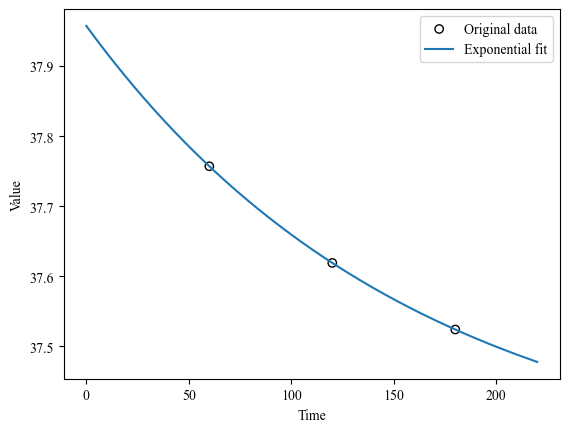

[ 3.73139056e+01  6.43352733e-01 -6.21373849e-03]


In [14]:
from scipy.optimize import curve_fit
import numpy as np

y = [37.7570381165, 37.6191291809, 37.5241394043]
x = [60, 120, 180]

import matplotlib.pyplot as plt

# Define the exponential model
def exp_model(x, a, b, c):
    return a + b * np.exp(c * x)

# Fit the exponential curve
params, _ = curve_fit(exp_model, x, y, p0=[1, 1, -0.01])

# Generate data for plotting the fitted curve
x_fit = np.linspace(0, 220, 1000)
y_fit = exp_model(x_fit, *params)

# Plot the original data and the fitted curve
plt.scatter(x, y, label='Original data', color='black', marker='o', facecolors='none')
plt.plot(x_fit, y_fit, label='Exponential fit', color='C0')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.savefig("Gráficos/legenda.pdf")

plt.show()

print(params)

[ 3.73139056e+01  6.43352733e-01 -6.21373849e-03]
[ 6.58958550e+01  4.23401967e-01 -3.34059000e-02]


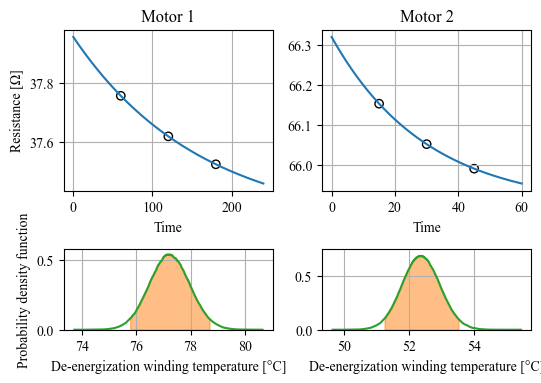

65.89585500398167
37.957258342287155
66.31925697107208


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fcn import estimate_model_with_uncertainty

x1 = np.array([60, 120, 180]) # Ponto 13 do Pacheco
y1 = np.array([37.7570381165, 37.6191291809, 37.5241394043]) # Ponto 13 do Pacheco
t_lim = 240

initial_params = [3.73139056e+01,  6.43352733e-01, -6.21373849e-03]

cm = 1/2.54  # centimeters in inches
plt.rcParams['font.family'] = 'Times New Roman'
# Create a figure and axis for temperature subplot
fig, (ax_top, ax_bottom) = plt.subplots(2, 2, figsize=(14*cm, 10*cm), height_ratios=[2,1])

params, _, _ = estimate_model_with_uncertainty(x1, y1, model=exp_model, initial_params=initial_params, maxit=100000000)
print(params)
x_fit = np.linspace(0, max(t_lim,x[-1]), 1000)
y_fit = exp_model(params, x_fit)
sse_exponential = np.sum((y1 - exp_model(params, x1))**2)
linear_params = np.polyfit(x1, y1, 1)
linear_fit = np.polyval(linear_params, x_fit)
sse_linear = np.sum((y1 - np.polyval(linear_params, x1))**2)
poly2_params = np.polyfit(x1, y1, 2)
poly2_fit = np.polyval(poly2_params, x_fit)
sse_poly2 = np.sum((y1 - np.polyval(poly2_params, x1))**2)

# First experiment (df)
ax_top[0].scatter(x1, y1, label='Original Data', color='black', marker='o', facecolors='none')
ax_top[0].plot(x_fit, y_fit, label=f'Exponential fit', color='C0')
ax_top[0].set_xlabel('Time')
ax_top[0].set_ylabel('Resistance [Ω]')
# ax_top[0].legend()
ax_top[0].set_title('Motor 1')
ax_top[0].grid()

x2 = np.array([15, 30, 45])
y2 = np.array([66.1523818970, 66.0512771606, 65.9900207520])
t_lim = 60

initial_params = [6.58958550e+01,  4.23401967e-01, -3.34059000e-02]

params2, _, _ = estimate_model_with_uncertainty(x2, y2, model=exp_model, initial_params=initial_params, maxit=100000000)
print(params2)
x_fit = np.linspace(0, max(t_lim,x[-1]), 1000)
y_fit2 = exp_model(params2, x_fit)
sse_exponential2 = np.sum((y2 - exp_model(params2, x2))**2)

ax_top[1].scatter(x2, y2, label='Original Data', color='black', marker='o', facecolors='none')
ax_top[1].plot(x_fit, y_fit2, label=f'Exponential fit', color='C0')
ax_top[1].set_xlabel('Time')
# ax_top[1].set_ylabel('Resistance')
# ax_top[1].legend()
ax_top[1].set_title('Motor 2')
ax_top[1].grid()

x_tot = np.array([15, 30, 45])

for k in range(2):
    if k == 0:
        dfFile = f"Resultados/embraco3.feather"
        dfMCVectors = f"Resultados/embraco3_MCvectors.feather"
    
    if k== 1:
        dfFile = f"Resultados/embraco2.feather"
        dfMCVectors = f"Resultados/embraco2_MCvectors.feather"


    data = pd.read_feather(dfFile)
    data = pd.merge(data, pd.read_feather(dfMCVectors), left_index=True, right_index=True)

    data = data.sort_values(by='T2')

    cm = 1/2.54  # centimeters in inches
    plt.rcParams['font.family'] = 'Times New Roman'

    nCurves = 2000

    ind = np.linspace(0, len(data)-1, nCurves, dtype=int)

    # Create a figure and axis for cdf subplot
    T2_all = data['T2'].values

    # Plot the PDF of Temperature
    n, bins, patches = ax_bottom[k].hist(T2_all, bins=1000, edgecolor='C0', alpha=0, density=True, label='_nolegend_', facecolor="none")
    n_filt = 10
    n = np.convolve(n, np.ones(n_filt)/n_filt, mode='valid')
    bins = bins[n_filt//2:-n_filt//2+1]
    ax_bottom[k].plot((bins[:-1] + bins[1:]) / 2, n, color='C2', label = 'Probability density function')
    ax_bottom[k].set_xlabel('De-energization winding temperature [°C]')
    if k== 0:
        ax_bottom[k].set_ylabel('Probability density function')

    # Calculate the coverage interval
    alpha = 0.05
    lower_bound = np.percentile(T2_all, alpha/2 * 100)
    upper_bound = np.percentile(T2_all, (1 - alpha/2) * 100)

    # Color the area of the coverage interval
    ax_bottom[k].fill_between((bins[:-1] + bins[1:]) / 2, 0, n, where=((bins[:-1] + bins[1:]) / 2 >= lower_bound) & ((bins[:-1] + bins[1:]) / 2 <= upper_bound), color='C1', alpha=0.5, label='95% Coverage Interval')

    # Add a legend to the subplot
    # ax3.legend()
    ax_bottom[k].grid()

plt.tight_layout()
plt.savefig("Gráficos/compareCompressor.pdf")
plt.show()


print(exp_model(params2, 1000))


R0_1 = exp_model(params, 0)
R0_2 = exp_model(params2, 0)

print(R0_1)
print(R0_2)